#### IMPORTING LIBRARYS


In [1]:
import time 
start=time.time()
import pandas as pd 
import numpy as np 
import seaborn as sns  
import nltk 
from nltk  import FreqDist,pos_tag
from random import randint 
#nltk.download('stopwords')
from nltk.corpus import stopwords,wordnet
import matplotlib.pyplot as plt  
from wordcloud import STOPWORDS,WordCloud  
from matplotlib import rcParams
from nltk.tokenize import sent_tokenize, word_tokenize  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import WordNetLemmatizer   
import spacy
from spacy import displacy 

#### LOADING AND PREPARING DATA

In [2]:

df_train=pd.read_csv("./data/train.csv") 
df_essays=pd.DataFrame(df_train["full_text"])
df_test=pd.read_csv("./data/test.csv")   
X=df_essays 
y=df_train.drop(["text_id","full_text"],axis=1)  
essays=df_essays["full_text"]
essays=list(essays) 
essays=" ".join(essays)  
essays=('''"""''') +essays + ('''"""''')  
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


## GLOBAL FUNCTIONS

In [3]:
english_words=[]
file=open("./data/actual_all_words.txt","r")  
wfile=file.readlines() 
for word in wfile: 
    english_words.append(word.lower()) 
for i in range(0,len(english_words)): 
    english_words[i]=english_words[i].replace("\n","") 
NER = spacy.load("en_core_web_sm") 

In [4]:
stop_words=stopwords.words("english")    
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner']) 
def remove_unwanted(string,unwanted):  
    for i in unwanted: 
        string=string.replace(i,"")
    return string    
def filter_text(string,stop_words=stop_words,unique_words=True,filter_by_sw=True): 
    string=remove_unwanted(string,["'",'"',".",",","`","!","?","´",':',"(",")","/","[","]"])  
    tokenized=word_tokenize(string) 
    filtered=tuple(tokenized)
    if filter_by_sw:
        filtered=tuple([word.casefold() for word in tokenized if word.casefold() not in stop_words])
    if unique_words:
        filtered =tuple(set(filtered))
    return filtered 
def get_num_words(string,unique_words=True,filter_by_sw=True):  
    filtered=filter_text(string,unique_words=unique_words,filter_by_sw=filter_by_sw)
    return len(filtered)
def makeWordcloud(text,stopwords=STOPWORDS,maxwords=300,width=800,height=800,color="black",column="fulltext"): 
    if isinstance(text,pd.core.frame.DataFrame):  
        newtext="\n".join(text[column])
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
    elif isinstance(text,str):  
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()
    elif isinstance(text,list) or isinstance(text,np.ndarray) or isinstance(text,pd.core.series.Series): 
        newtext=" ".join(text)
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
def create_txt_with_example(specific=randint(0,len(df_train["full_text"]))): 
    newExample=open("./examples/example_%d.txt" % specific,"w") 
    newExample.write(df_train["full_text"][specific]) 
    newExample.close()  
def getcommonwords(text,amount=10):  
    filtered=filter_text(text,unique_words=False) 
    freq=FreqDist(filtered) 
    return tuple([word[0] for word in freq.most_common(amount)]) 
def pos_tag_text(text,filter=False,to_dic=False): 
    tagged=pos_tag(text) 
    return tagged
def mistakeCounter(essay): 
    counter=0 
    filtered_text=filter_text(essay,filter_by_sw=False,unique_words=False)  
    a=[]
    for word in filtered_text: 
        if word.lower() not in english_words:  
           a.append(word)   
    NerText=NER(" ".join(a)) 
    for word in NerText.ents: 
        if word.label_ == "PERSON" or word.label_ == "ORG" or word.label_ == "LOC" or word.label_ == "DATE" or word.label_ == "MONEY"   or word.label_ == "PRODUCT" or word.label_ == "WORK_OF_ART" or word.label_ == "FAC" or word.label_ == "EVENT" or word.label_ == "GPE" or  word.label_ == "TIME" or  word.label_ == "PERCENT" or word.label_ == "NORP" :
            words=word_tokenize(word.text) 
            for j in words:  
                if j in a:
                    a.remove(j)
    final=a 
    for word in a: 
        if len(wordnet.synsets(word)) == 0:  
            if word in final: 
                final.remove(word) 
    return len(final)  
def getradicals(essay): 
    load_model = spacy.load('en_core_web_sm', disable = ['parser','ner']) 
    e_string=df_essays["full_text"][3385]  
    doc=load_model(" ".join(filter_text(e_string,unique_words=False))) 
    radicals=[token.lemma_ for token in doc] 
    return radicals  
def amountRadicals(essay): 
    radicals=getradicals(essay) 
    return len(radicals)

### testing example

In [5]:
""" theone=randint(0,3900)
e_string=df_essays["full_text"][theone] 
print("randon num: %d" % theone)
mistakeCounter(e_string) """

' theone=randint(0,3900)\ne_string=df_essays["full_text"][theone] \nprint("randon num: %d" % theone)\nmistakeCounter(e_string) '

In [6]:
df_relevant=df_train  

## CREATE AN EXAMPLE txt

In [7]:
create_txt_with_example(1166)  

## ADDING RELEVANT INFORMATION

### guide to pos_tag

In [8]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### GUIDE TO NER

In [9]:
NER.get_pipe('ner').labels 

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

### ADDING NUMBER OF WORDS PER ESSAY

In [10]:
df_train["full_text"]
e_string=df_essays["full_text"][300]
df_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] 
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,131
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,217
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,141
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,303
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112
...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,216
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,235


### ADDING 10 MOST COMMON WORDS OF EACH ESSAY

In [11]:
df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,131,"(students, go, u, wont, get, classes, home, sc..."
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,217,"(change, different, see, understand, need, thi..."
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,141,"(average, sports, school, activities, policy, ..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,303,"(make, choices, dont, others, want, people, be..."
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"(people, act, change, kindess, person, nice, i..."
...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"(believe, could, using, cellphones, use, us, s..."
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,216,"(students, work, group, working, get, student,..."
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"(problem, best, every, get, chance, quote, don..."
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,235,"(others, people, example, influence, matter, s..."


### ADDING HOW MANY ORTOGRAPHY ERRORS

In [12]:
df_relevant["mistakes"]=[mistakeCounter(essay) for essay in df_train["full_text"]] 
df_relevant     

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,mistakes
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,131,"(students, go, u, wont, get, classes, home, sc...",1
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,217,"(change, different, see, understand, need, thi...",0
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,141,"(average, sports, school, activities, policy, ...",0
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,303,"(make, choices, dont, others, want, people, be...",0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"(people, act, change, kindess, person, nice, i...",5
...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"(believe, could, using, cellphones, use, us, s...",11
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,216,"(students, work, group, working, get, student,...",9
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"(problem, best, every, get, chance, quote, don...",5
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,235,"(others, people, example, influence, matter, s...",2


### GETTING RADICALS

In [13]:
df_relevant["amt_radicals"]=[amountRadicals(essay) for essay in df_train["full_text"]]

### saving relevant data to cvs

## VISUALIZING DATA 

### SEEING REGULAR WORD CLOUD

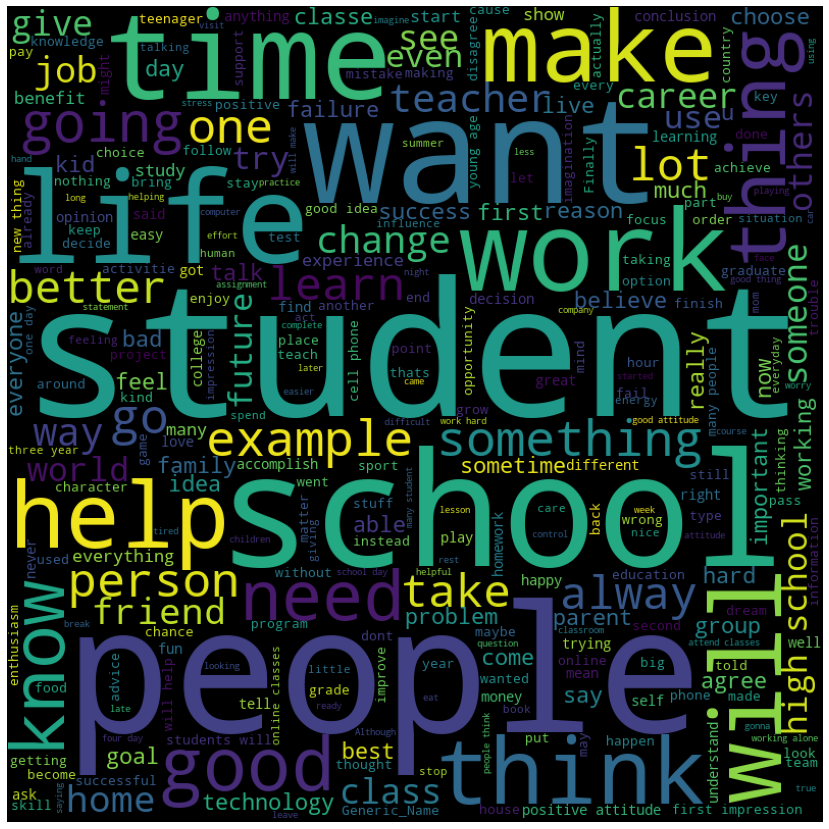

In [14]:
makeWordcloud(essays) 

### SEEING WORDCLOUD OF RADICALS

In [15]:
radicals=getradicals(essays)

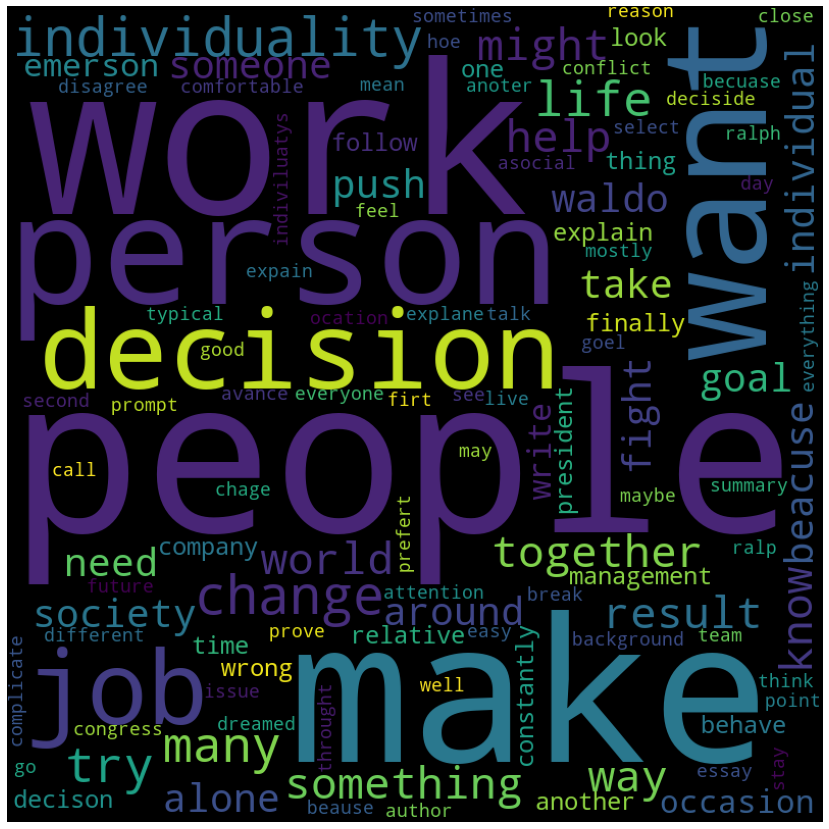

In [16]:
makeWordcloud(" ".join(radicals)) 

### SEEING HISTOGRAM OF EACH TARGET

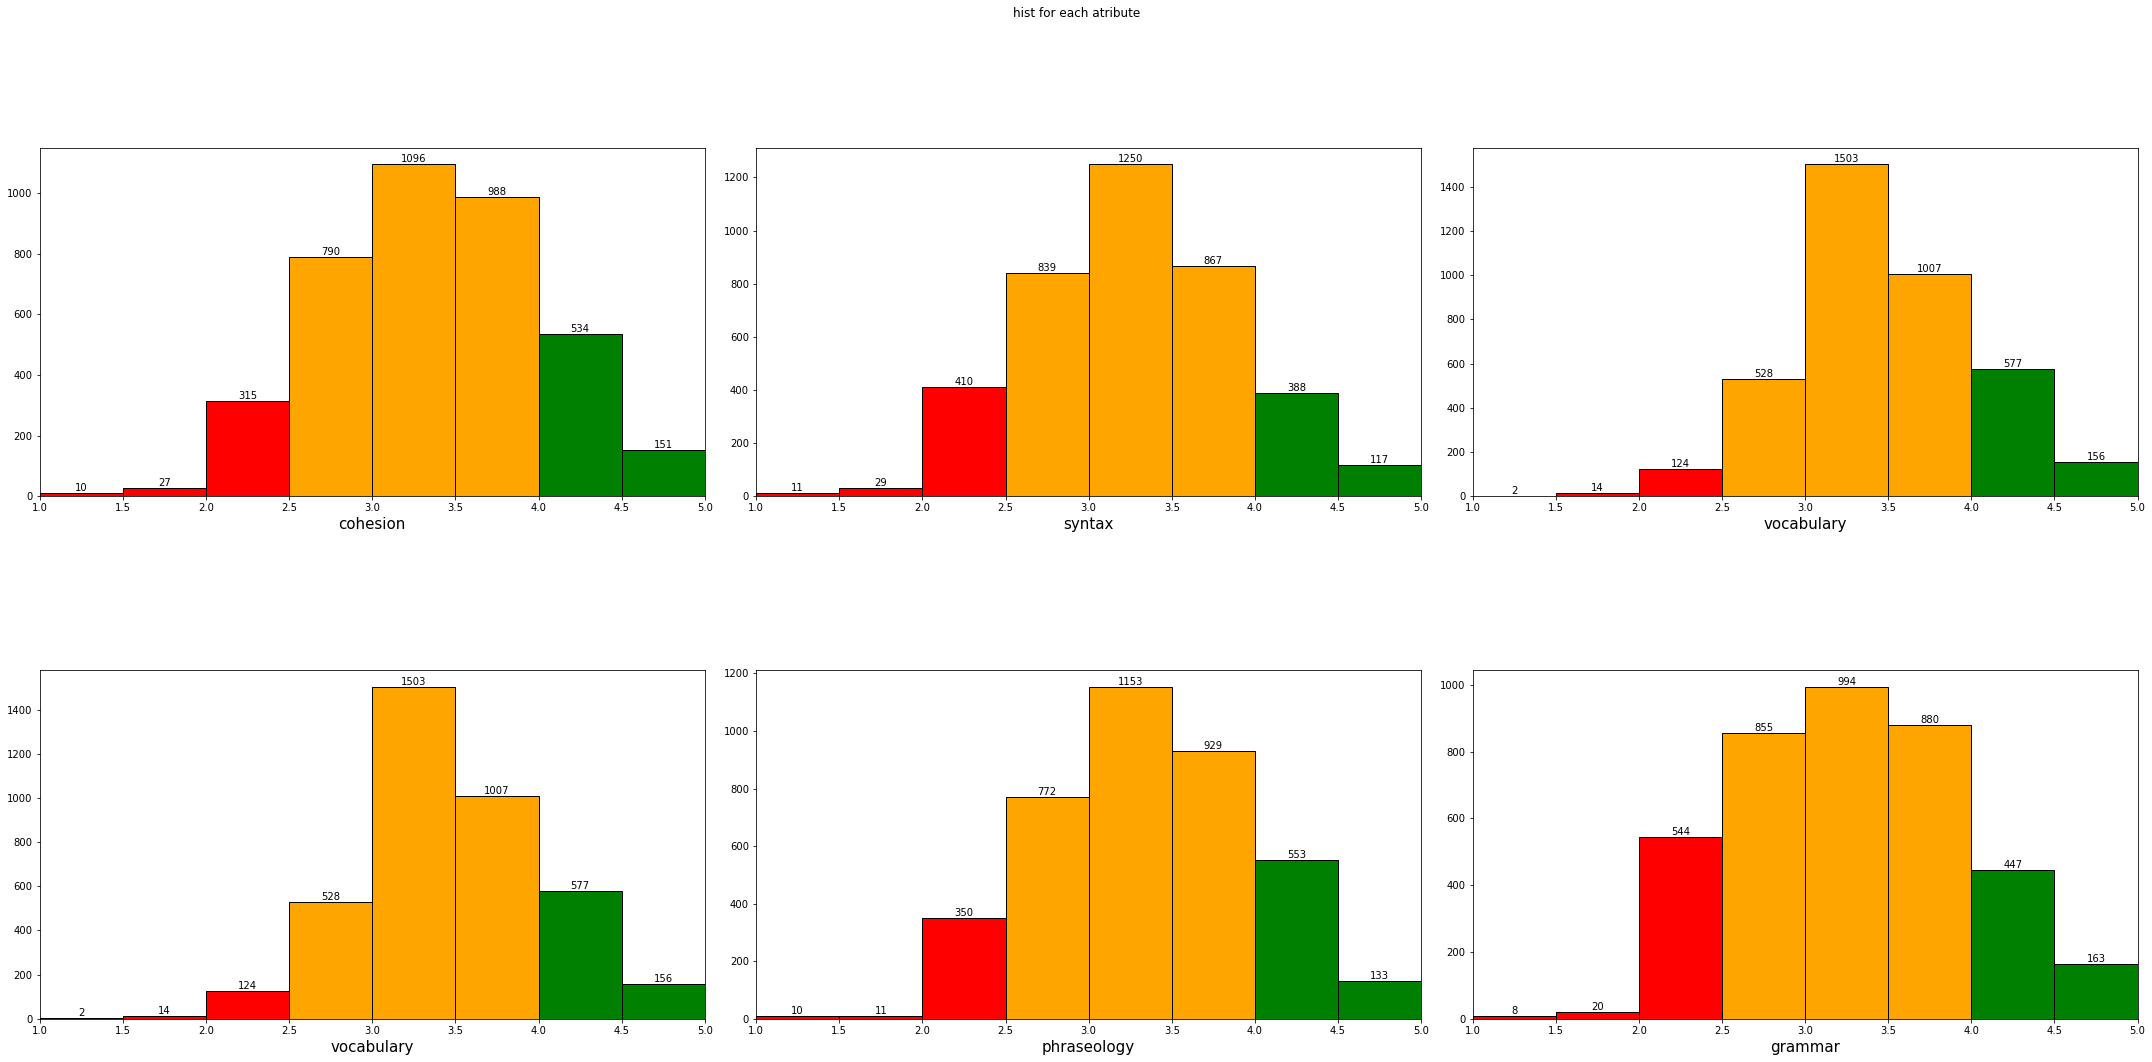

In [17]:

fig,ax =plt.subplots(2,3) 
fig.suptitle("hist for each atribute")   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j
        N, bins, patches=ax[i,j].hist(y[target_names[oneDIndex]],edgecolor="black",bins=8)   
        for k in range(0,3):
            patches[k].set_facecolor("red") 
        for k in range(3,6): 
            patches[k].set_facecolor("orange")
        for k in range(6,len(patches)):  
            patches[k].set_facecolor("green")
        ax[i,j].bar_label(patches)
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15)  
        ax[i,j].set_xbound(lower=1.0,upper=5.0)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

### SEEING MOST COMMON WORDS FREQUENCY

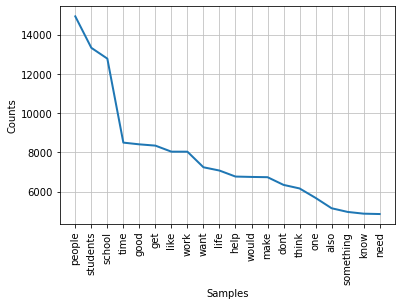

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
filtered_words=filter_text(essays,unique_words=False) 
common=FreqDist(filtered_words)
common.plot(20)

## Running time

In [19]:
end=time.time() 
print(end-start)

3733.6251056194305


## SAVING RELEVANT FILE TO CSV

In [20]:
df_relevant.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,mistakes,amt_radicals
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.0
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,200.641013,3.694963,287.0
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450,87.842917,4.784328,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,287.0
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,138.000000,0.000000,287.0
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,188.000000,2.000000,287.0
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,248.000000,5.000000,287.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,593.000000,69.000000,287.0


In [24]:
df_relevant.columns=["text_id","full_text","cohesion","syntax","vocabulary","phraseology","grammar","conventions","n_of_words","most_common_words","ort_mistakes","amt_radicals"] 
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words,ort_mistakes,amt_radicals
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,131,"(students, go, u, wont, get, classes, home, sc...",1,287
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,217,"(change, different, see, understand, need, thi...",0,287
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,141,"(average, sports, school, activities, policy, ...",0,287
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,303,"(make, choices, dont, others, want, people, be...",0,287
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"(people, act, change, kindess, person, nice, i...",5,287
...,...,...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"(believe, could, using, cellphones, use, us, s...",11,287
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,216,"(students, work, group, working, get, student,...",9,287
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,109,"(problem, best, every, get, chance, quote, don...",5,287
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,235,"(others, people, example, influence, matter, s...",2,287


In [26]:
df_relevant.to_csv("./relevant/relevant.csv")